In [1]:
#%% Importing modules and data
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import quandl as qd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from pandas_datareader import data

%matplotlib inline

def save_xls(list_dfs, xls_path,sheet_names):
    writer = ExcelWriter(xls_path)
    for n, df in enumerate(list_dfs):
        df.to_excel(writer, sheet_names[n])
    writer.save()
    return

In [6]:


# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# Use site: http://optionsforum.net/topic/268/50-stocks-with-most-liquid-options
'''
tickers = ['ABT', 'ABBV', 'PNR', 'CL', 'HRL', 'CLX', 'LOW', 'PG', 'BCR', 'PEP', 'CTAS',
          'XOM', 'EMR', 'PPG', 'GWW', 'ADM', 'TGT', 'AFL', 'ED', 'MMM', 'SHW', 'CVX',
          'WBA', 'SPGI', 'JNJ', 'DOV', 'KO', 'SWK', 'CAH', 'MCD', 'APD', 'FRT', 'VFC',
          'KMB', 'WMT', 'BDX', 'GPC', 'ADP', 'LEG', 'TROW', 'ECL', 'CINF', 'MDT', 'MKC',
          'ITW', 'BEN', 'NUE', 'SYY', 'T', 'GD']
'''
tickers = pd.read_csv('dec18list.csv')
tickers = list(tickers['Ticker'])
#tickers = ['TSN','JD']
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2007-01-01'
end_date = '2017-12-14'

start = dt.datetime(2007, 1, 1)
end = dt.datetime.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, data_source, start, end)

# panel_data.minor_xs('SPY')

# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = panel_data.ix['Close']

# Getting all weekdays between start_date and end_date
#all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [3]:
# Function for calculating standard dev and price moves in terms of standard dev
# DF[[Adj Close]] Rolling Period --> DF[['Daily Vol','Daily Price Vol','Price Dev','Annual Vol']]
def price_devs(close_prices,roll_period,plot_window, hist_window,ticker):
    df = close_prices.copy()
    df.columns = ['prices']
    df['prices_delta'] = df.prices - df.prices.shift(1)
    df['log_returns'] = np.log(df.prices) - np.log(df.prices.shift(1))
    df['daily_vol'] = st.rolling_std(df.log_returns, roll_period, ddof = 1)
    df['daily_vol_dollar'] = df.daily_vol*df.prices
    df['price_dev'] = df.prices_delta/df.daily_vol_dollar.shift(1)
    df['annual_vol'] = df.daily_vol*np.sqrt(252)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    
    df['price_dev'].tail(plot_window).plot(kind = 'bar',ax=axes[0,0], rot=20)
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.tail(plot_window).index)
    # Every ith ticklable shows the month and day
    i = int(plot_window/10)
    ticklabels[::i] = [item.strftime('%b %d %Y') for item in df.tail(plot_window).index[::i]]
    # Every jth ticklabel includes the year
    j = i
    ticklabels[::j] = [item.strftime('%b %d\n%Y') for item in df.tail(plot_window).index[::j]]
    #axes[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter(ticklabels))
    axes[0,0].set_xlabel('')
    axes[0,0].set_xticklabels(ticklabels)
    
    df.tail(hist_window).price_dev.hist(bins = 20,ax=axes[0,1])
    df.tail(hist_window)[df.price_dev < 0].price_dev.hist(bins = 10,ax=axes[1,0])
    df.tail(hist_window)[df.price_dev >= 0].price_dev.hist(bins = 10,ax=axes[1,1])
    
    axes[0,0].set_title('Period Price Deviations')
    axes[0,1].set_title('Distribution of Price Deviations')
    axes[1,0].set_title('Left-Side Distribution')
    axes[1,1].set_title('Right-Side Distribution')
    fig.suptitle(ticker,fontsize=20)
    print(df.tail(5))
    return df

In [4]:
def vol_summary(adj_c_df,rolling_period,lookback_window,hist_window,ticker):
    etf = price_devs(adj_c_df,rolling_period,lookback_window,hist_window,ticker)
    
    # Describing Deviation Data
    obs = hist_window

    #print(etf.price_dev.tail(obs).describe())#percentiles = list(np.arange(0.1,1,0.1))))
    print('---------------------')
    # Finding date of largest drop
    print('Date of largest drop')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmin())])
    print(etf.price_dev.tail(obs).idxmin())
    print('---------------------')
    # Finding date of largest spike
    print('Date of largest spike')
    print(etf.price_dev.tail(obs).iloc[etf.price_dev.tail(obs).index.get_loc(etf.price_dev.tail(obs).idxmax())])
    print(etf.price_dev.tail(obs).idxmax())
    print('---------------------')
    # Histogram Bins
    d = {'Std Bins':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[1][:-1],
        'Frequency':np.histogram(etf.price_dev.tail(obs), 40, (-20,20))[0]}
    df = pd.DataFrame(d,index = d['Std Bins'])[['Frequency']]
    #print(df)
    return df, etf

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  


               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2007-01-09  17.820000      0.050000     0.002810   0.011941          0.212794   
2007-01-08  17.860001      0.040001     0.002242   0.011780          0.210387   
2007-01-05  17.639999     -0.220002    -0.012395   0.013939          0.245883   
2007-01-04  17.680000      0.040001     0.002265   0.007421          0.131212   
2007-01-03  17.510000     -0.170000    -0.009662   0.007749          0.135686   

            price_dev  annual_vol  
Date                               
2007-01-09   0.178117    0.189562  
2007-01-08   0.187980    0.186998  
2007-01-05  -1.045701    0.221274  
2007-01-04   0.162683    0.117812  
2007-01-03  -1.295618    0.123012  
---------------------
Date of largest drop
-7.79606126872
2008-04-17 00:00:00
---------------------
Date of largest spike
4.94894681012
2008-09-05 00:00:00
---------------------


C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


3.5371642927402811

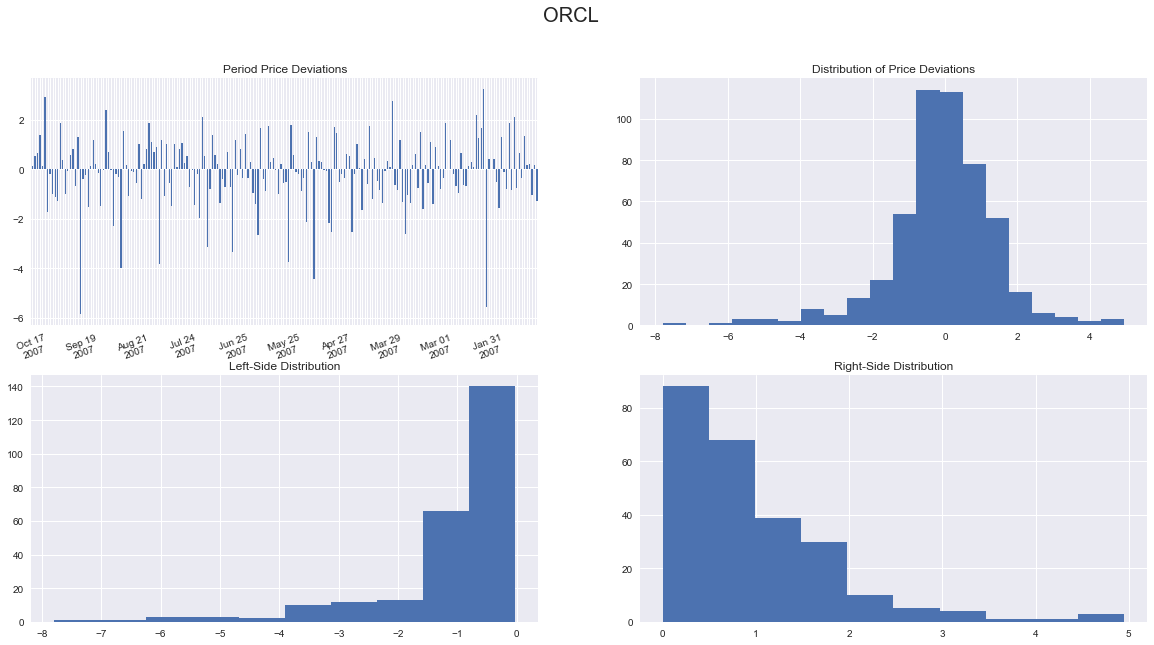

In [13]:
rolling_period = 4
lookback_window = 200
hist_window = 500
ticker = 'ORCL'
summary, full_df = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)
full_df['price_dev'].dropna().skew()

C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).std(ddof=1)
  
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fang\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


               prices  prices_delta  log_returns  daily_vol  daily_vol_dollar  \
Date                                                                            
2007-01-09  50.430000      0.180000     0.003576   0.006063          0.305746   
2007-01-08  49.860001     -0.569999    -0.011367   0.007225          0.360233   
2007-01-05  49.880001      0.020000     0.000401   0.007684          0.383302   
2007-01-04  50.869999      0.989998     0.019653   0.012791          0.650667   
2007-01-03  50.950001      0.080002     0.001571   0.012803          0.652333   

            price_dev  annual_vol  
Date                               
2007-01-09   0.763926    0.096244  
2007-01-08  -1.864288    0.114692  
2007-01-05   0.055520    0.121987  
2007-01-04   2.582815    0.203047  
2007-01-03   0.122954    0.203248  
---------------------
Date of largest drop
-18.4374856829
2007-07-12 00:00:00
---------------------
Date of largest spike
8.45808221886
2008-09-19 00:00:00
---------------------
  

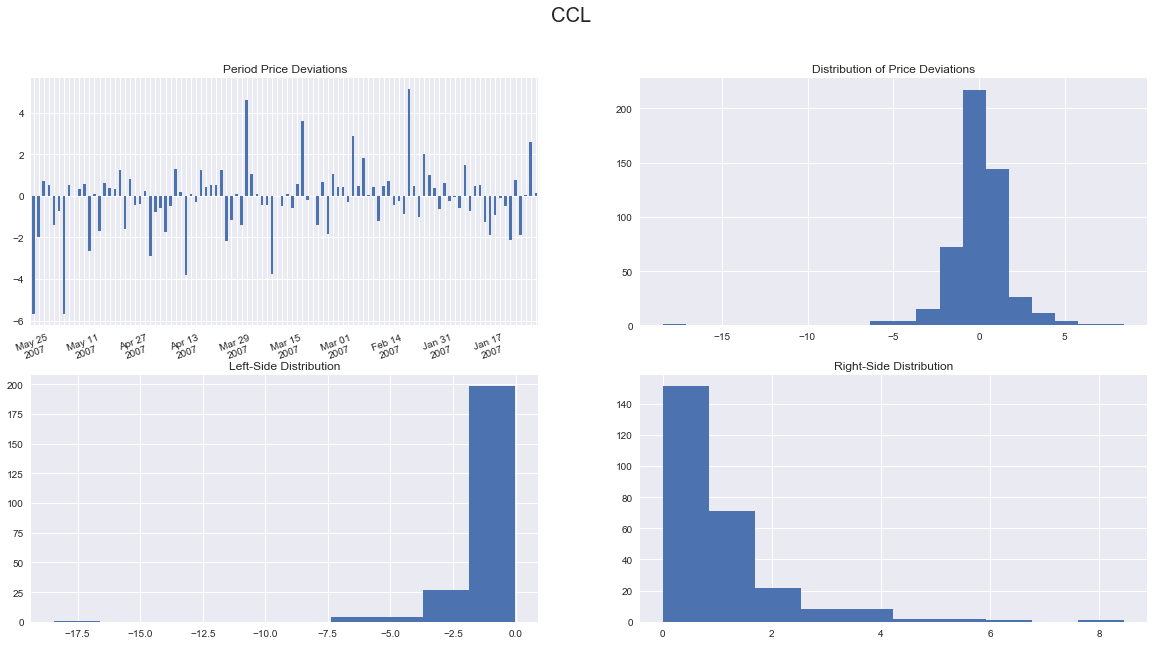

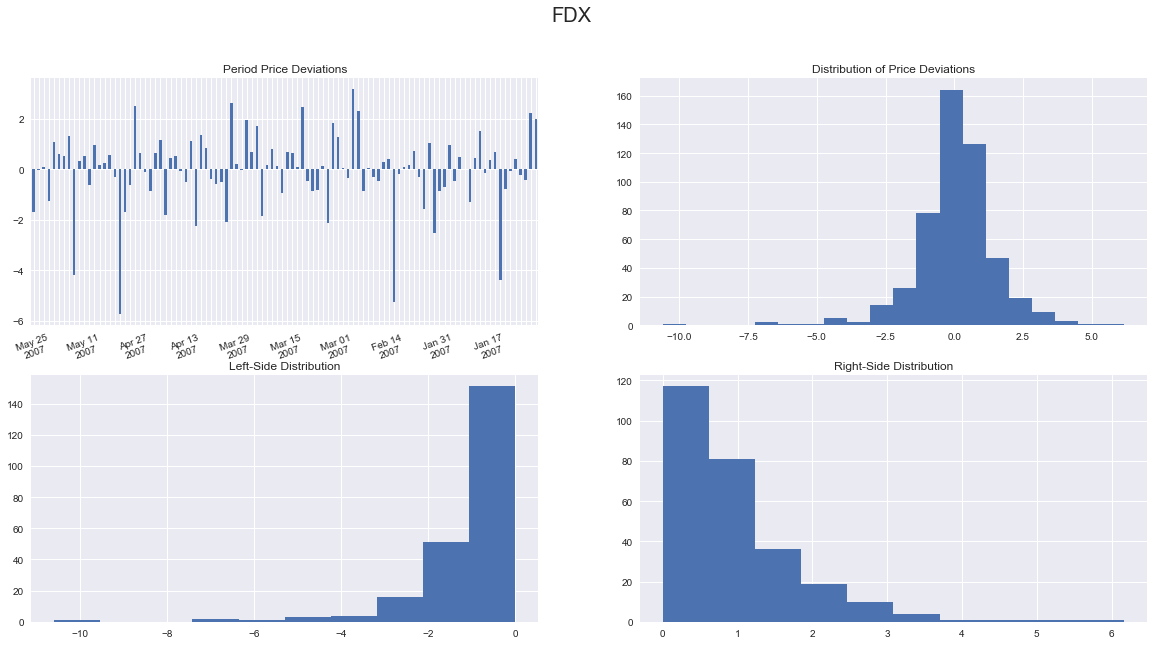

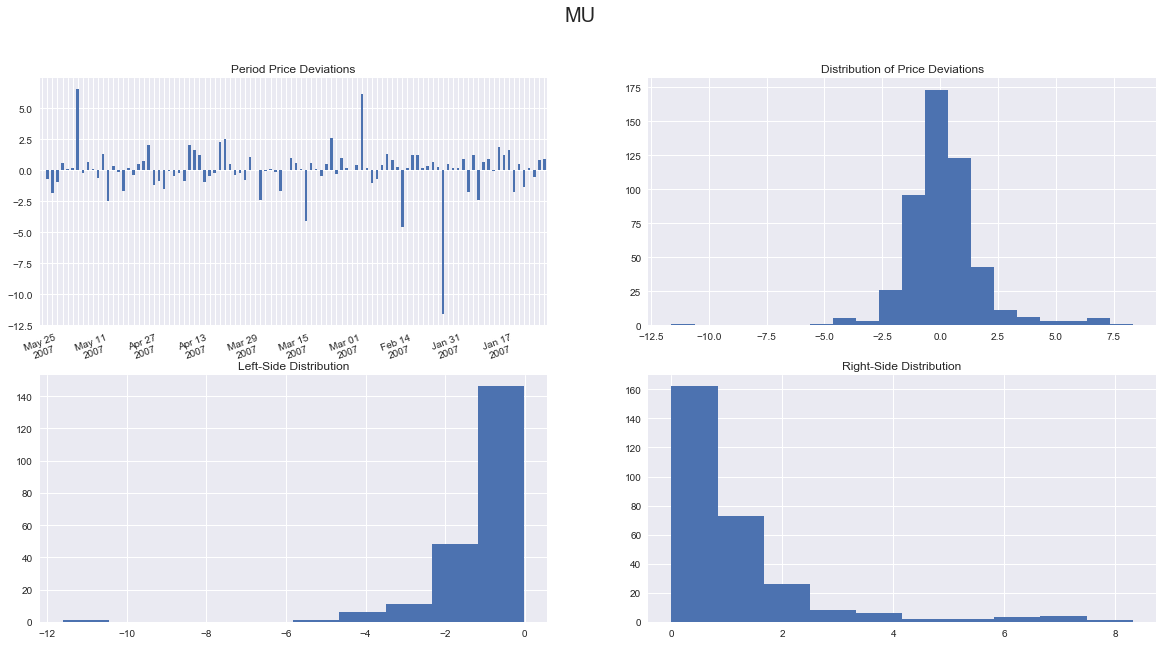

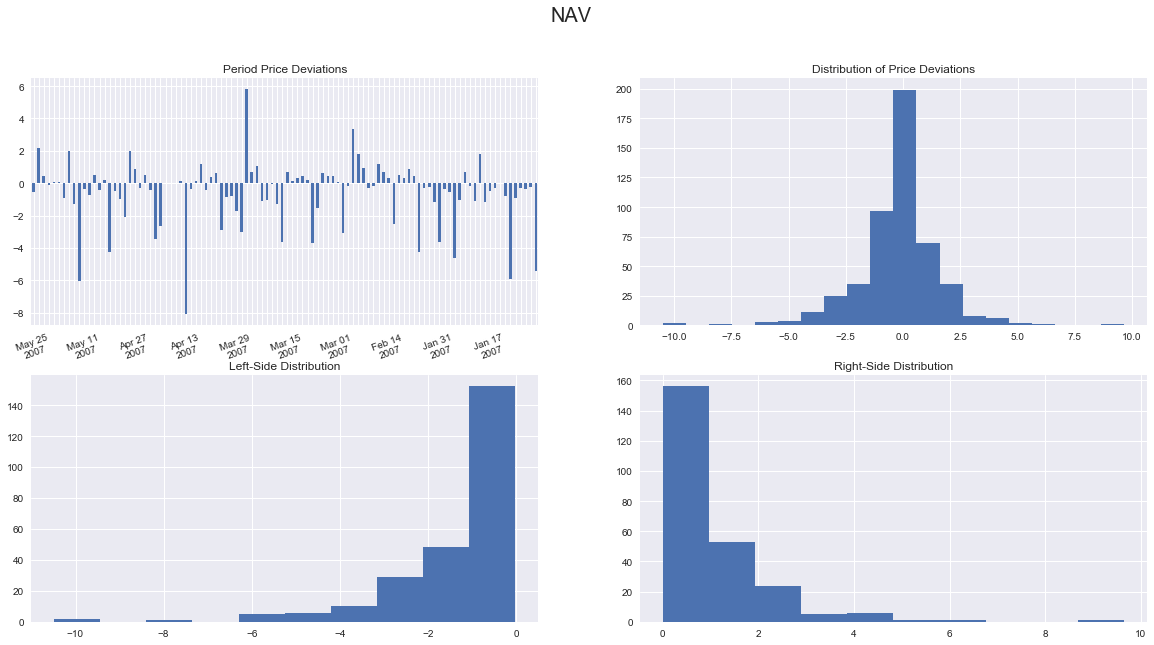

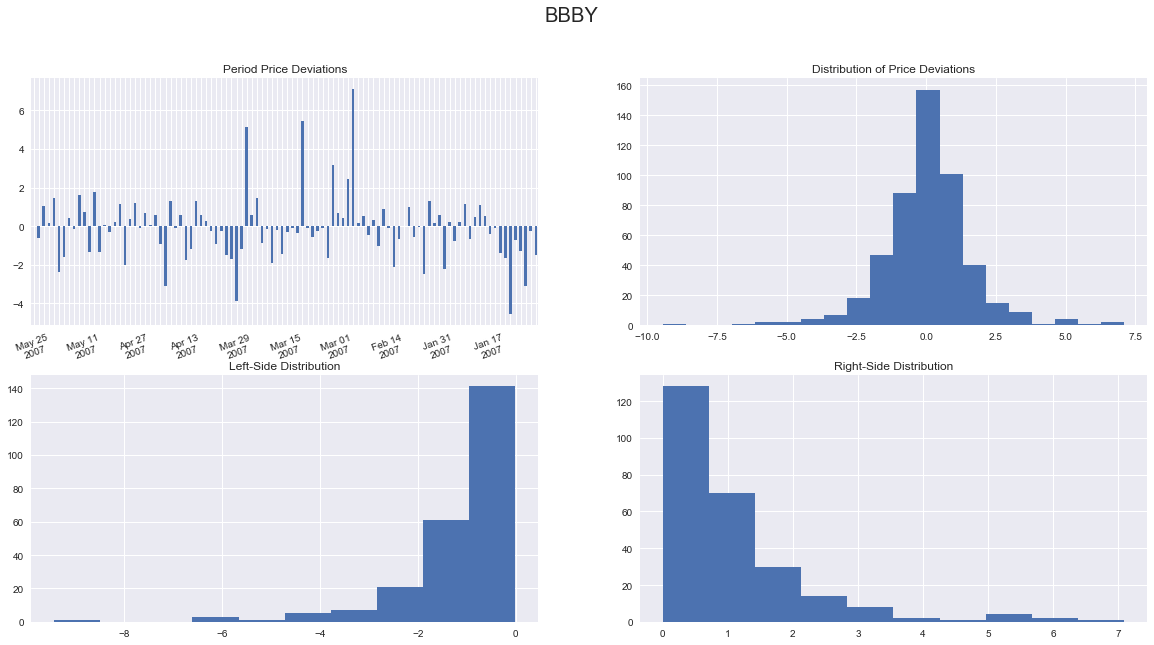

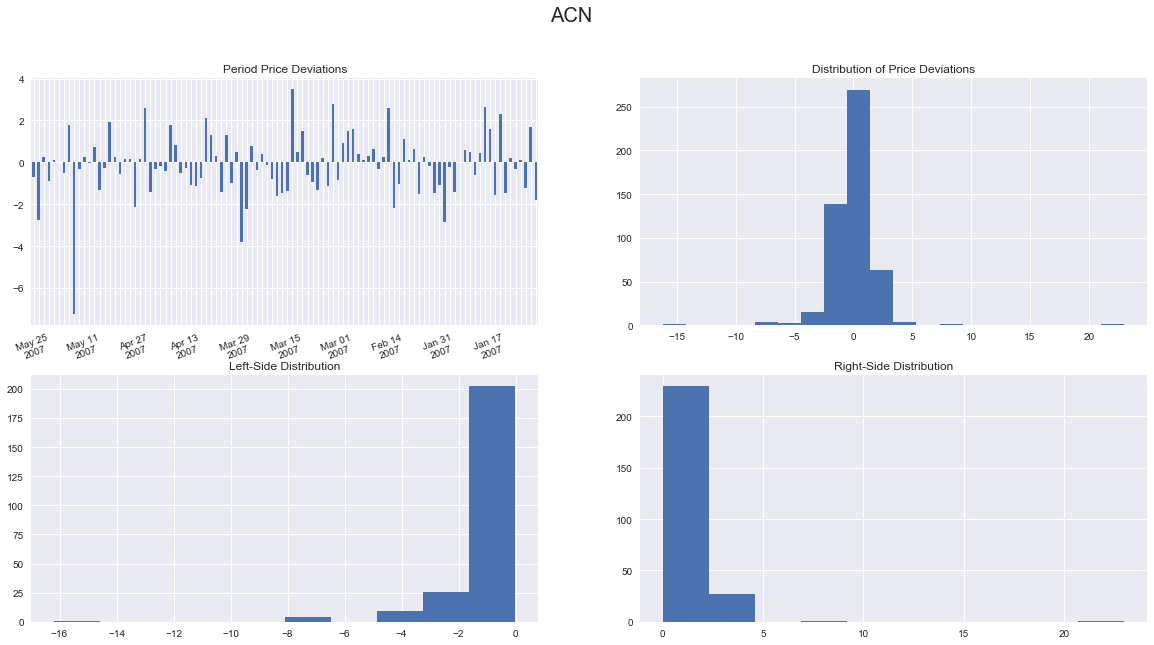

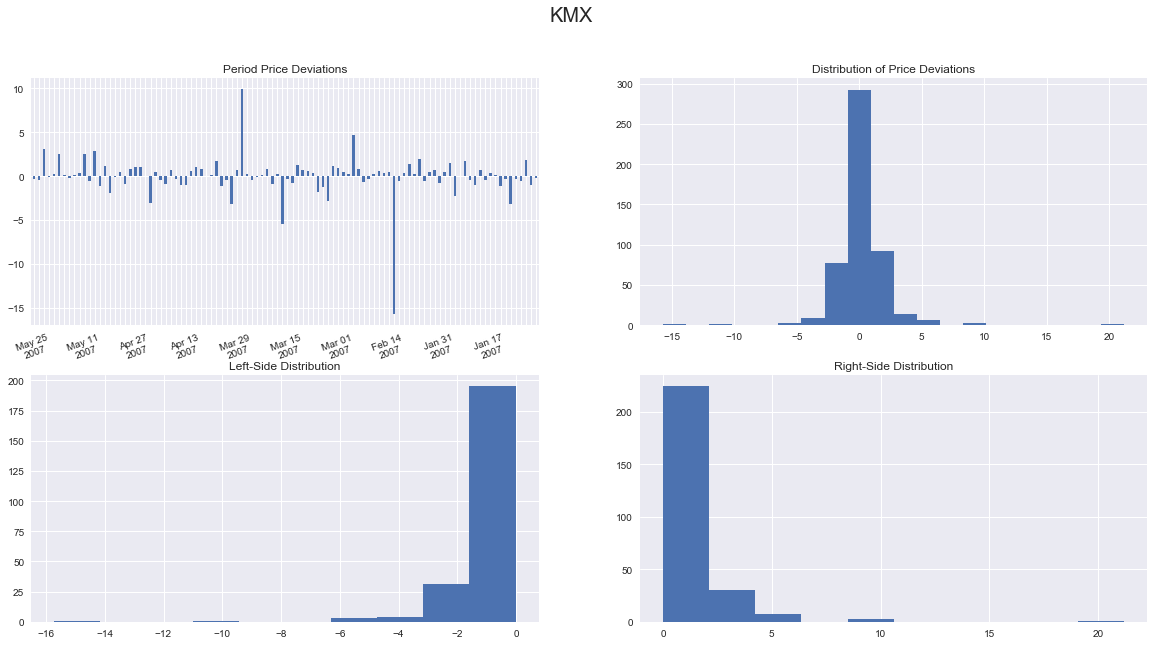

In [7]:
rolling_period = 4
lookback_window = 100
hist_window = 500
for ticker in tickers:
    stock = vol_summary(close[[ticker]],rolling_period,lookback_window,hist_window,ticker)

In [8]:
dic = {}
clse = []
tkers = []
for ticker in tickers:
    clse = clse + [close[[ticker]].iloc[-1][ticker]]
    tkers = tkers + [ticker]
    
dic['Close'] = clse
dic['Ticker'] = tkers
pd.DataFrame(dic)

,Close,Ticker
0,50.950001,CCL
1,109.769997,FDX
2,14.030000,MU
3,34.009998,NAV
4,38.290001,BBBY
5,36.380001,ACN
6,27.645000,KMX


In [8]:
tickers

['ADBE', 'COST', 'JBL', 'ORCL']

In [14]:
full_df['price_dev'].dropna().skew()

0.75157125093740373

In [15]:
full_df['price_dev'].dropna().describe()

count    2605.000000
mean        0.057219
std         1.819942
min       -11.782973
25%        -0.655835
50%         0.013202
75%         0.782285
max        24.518553
Name: price_dev, dtype: float64

In [28]:
std_thresh = 4

down_nums = summary[summary.index <= -std_thresh].sum()
up_nums = summary[summary.index >= std_thresh].sum()

print("Threshold stdev: {0} \nNumber of deviations downward: {1} \nNumber of deviations upward: {2}".format(std_thresh,
                                                                                                           down_nums,
                                                                                                           up_nums))

Threshold stdev: 4 
Number of deviations downward: Frequency    7
dtype: int64 
Number of deviations upward: Frequency    10
dtype: int64


In [16]:
full_df.to_csv('avgo.csv')